<a href="https://colab.research.google.com/github/ParthPatel101/iSPY/blob/main/iSPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This program uses LSTM (Long Short Term Memory) to predict the stock price of the SPY 500 index using past data.

In [79]:
import math
import pandas_datareader as web
import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [80]:
# Full dataset from the start of SPY to today
start = dt.datetime(1993, 1, 1)
end = dt.datetime.today()
df = web.get_data_yahoo("SPY", start = start, end = end)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1993-01-29,43.968750,43.750000,43.968750,43.937500,1003200.0,25.438101
1993-02-01,44.250000,43.968750,43.968750,44.250000,480500.0,25.619013
1993-02-02,44.375000,44.125000,44.218750,44.343750,201300.0,25.673304
1993-02-03,44.843750,44.375000,44.406250,44.812500,529400.0,25.944679
1993-02-04,45.093750,44.468750,44.968750,45.000000,531500.0,26.053247
...,...,...,...,...,...,...
2022-07-11,386.869995,383.500000,385.850006,384.230011,58366900.0,384.230011
2022-07-12,386.160004,378.989990,383.649994,380.829987,62219200.0,380.829987
2022-07-13,381.920013,374.660004,375.100006,378.829987,84224600.0,378.829987


In [82]:
# More recent dataset (past 20 years)
recent_start = dt.datetime.today() - relativedelta(years = 20)
recent_df = web.get_data_yahoo("SPY", start = recent_start, end = end)
recent_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-07-17,93.300003,89.750000,92.459999,90.739998,48880600.0,61.779976
2002-07-18,91.099998,87.750000,90.699997,87.800003,32656700.0,59.778286
2002-07-19,87.550003,84.300003,86.760002,84.709999,77572600.0,57.674469
2002-07-22,85.910004,81.449997,84.099998,82.199997,78134000.0,55.965542
2002-07-23,83.239998,79.750000,82.550003,79.949997,74484100.0,54.433598
...,...,...,...,...,...,...
2022-07-11,386.869995,383.500000,385.850006,384.230011,58366900.0,384.230011
2022-07-12,386.160004,378.989990,383.649994,380.829987,62219200.0,380.829987
2022-07-13,381.920013,374.660004,375.100006,378.829987,84224600.0,378.829987


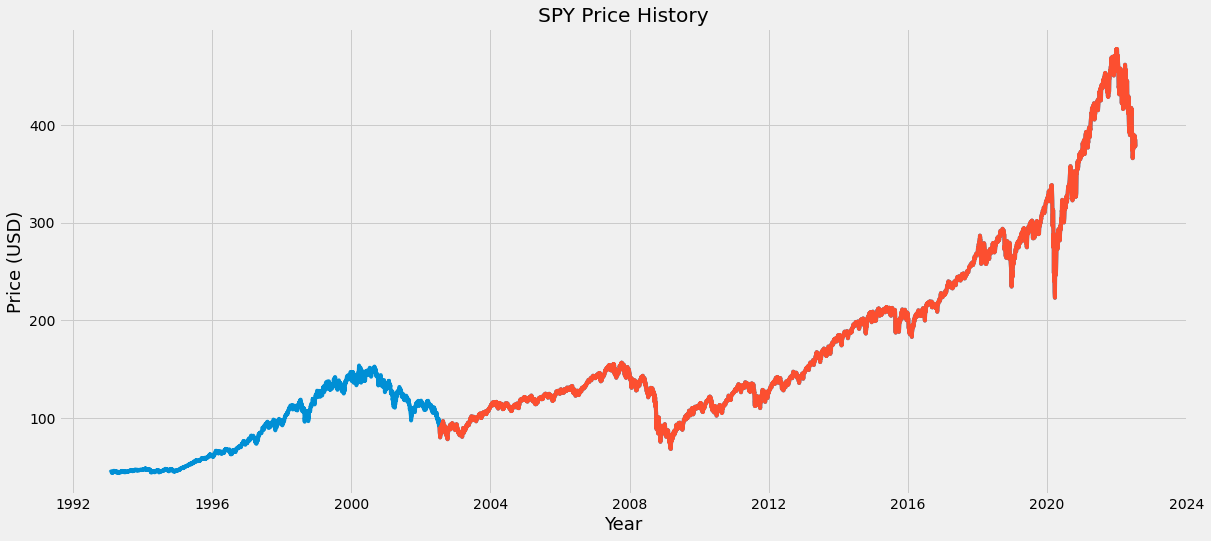

In [83]:
plt.figure(figsize=(18,8))
plt.title("SPY Price History")
plt.plot(df["Close"])
plt.plot(recent_df["Close"]) # Plots the recent subset of the total dataset in a different color
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Price (USD)", fontsize = 18)
plt.show()

In [84]:
data = df.filter(["Close"])
dataset = data.values
training_data_length = math.ceil(len(dataset) * 0.95) # Training data percentage is high because predictions are largely based on very recent activity
print(training_data_length)

recent_data = recent_df.filter(["Close"])
recent_dataset = recent_data.values
recent_training_data_length = math.ceil(len(recent_dataset) * 0.95) # Training data percentage is high because predictions are largely based on very recent activity
print(recent_training_data_length)


7049
4784


In [85]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

print()

recent_scaled_data = scaler.fit_transform(recent_dataset)
print(recent_scaled_data)

[[0.00122322]
 [0.00194276]
 [0.00215863]
 ...
 [0.77232523]
 [0.77020694]
 [0.78683125]]

[[0.05524902]
 [0.0480713 ]
 [0.04052734]
 ...
 [0.75859373]
 [0.75634768]
 [0.77397464]]


In [86]:
train_data = scaled_data[0:training_data_length]
x_train = []
y_train = []
for i in range(60, training_data_length):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 60:
    print(x_train)
    print(y_train)
    print()

recent_train_data = recent_scaled_data[0:recent_training_data_length]
recent_x_train = []
recent_y_train = []
for i in range(60, recent_training_data_length):
  recent_x_train.append(recent_train_data[i-60:i, 0])
  recent_y_train.append(recent_train_data[i, 0])
  if i <= 60:
    print(recent_x_train)
    print(recent_y_train)
    print()

[array([1.22322225e-03, 1.94276475e-03, 2.15862750e-03, 3.23794125e-03,
       3.66966675e-03, 3.59771250e-03, 3.59771250e-03, 2.87817000e-03,
       3.02207850e-03, 3.52575825e-03, 2.73426150e-03, 1.43908500e-04,
       7.19542500e-05, 0.00000000e+00, 3.59771250e-04, 7.19542500e-04,
       6.47588250e-04, 1.94276475e-03, 2.15862750e-03, 2.30253600e-03,
       2.01471900e-03, 3.52575825e-03, 3.95748375e-03, 3.38184975e-03,
       3.09403275e-03, 5.39656875e-03, 5.03679750e-03, 5.25266025e-03,
       4.96484325e-03, 3.88552950e-03, 4.38920925e-03, 4.38920925e-03,
       3.74162100e-03, 4.38920925e-03, 3.74162100e-03, 3.16598700e-03,
       3.38184975e-03, 3.38184975e-03, 4.02943800e-03, 3.45380400e-03,
       3.88552950e-03, 4.17334650e-03, 4.10139225e-03, 3.74162100e-03,
       1.58299350e-03, 2.08667325e-03, 1.79885625e-03, 2.15862750e-03,
       2.01471900e-03, 3.45380400e-03, 3.66966675e-03, 3.52575825e-03,
       3.52575825e-03, 3.52575825e-03, 3.09403275e-03, 2.59035300e-03,
     

In [87]:
x_train, y_train = np.array(x_train), np.array(y_train)

recent_x_train, recent_y_train = np.array(recent_x_train), np.array(recent_y_train)

In [88]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

recent_x_train = np.reshape(recent_x_train, (recent_x_train.shape[0], recent_x_train.shape[1], 1))
print(recent_x_train.shape)

(6989, 60, 1)
(4724, 60, 1)


In [89]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

recent_model = Sequential()
recent_model.add(LSTM(50, return_sequences = True, input_shape = (recent_x_train.shape[1],1)))
recent_model.add(LSTM(50, return_sequences = False))
recent_model.add(Dense(25))
recent_model.add(Dense(1))

In [90]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

recent_model.compile(optimizer = "adam", loss = "mean_squared_error")

In [91]:
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

recent_model.fit(recent_x_train, recent_y_train, batch_size = 1, epochs = 1)

4724/4724 [==============================] - 147s 31ms/step - loss: 5.3190e-04


In [92]:
test_data = scaled_data[training_data_length - 60:]
x_test = []
y_test = dataset[training_data_length:]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

recent_test_data = recent_scaled_data[recent_training_data_length - 60:]
recent_x_test = []
recent_y_test = recent_dataset[recent_training_data_length:]
for i in range(60, len(recent_test_data)):
  recent_x_test.append(recent_test_data[i-60:i,0])

In [93]:
x_test = np.array(x_test)

recent_x_test = np.array(recent_x_test)

In [94]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

recent_x_test = np.reshape(recent_x_test, (recent_x_test.shape[0], recent_x_test.shape[1], 1))


In [95]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

recent_predictions = recent_model.predict(recent_x_test)
recent_predictions = scaler.inverse_transform(recent_predictions)


In [96]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(rmse)

recent_rmse = np.sqrt(np.mean(recent_predictions - recent_y_test)**2)
print(recent_rmse)

4.270052770666174
2.7922459332591507


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

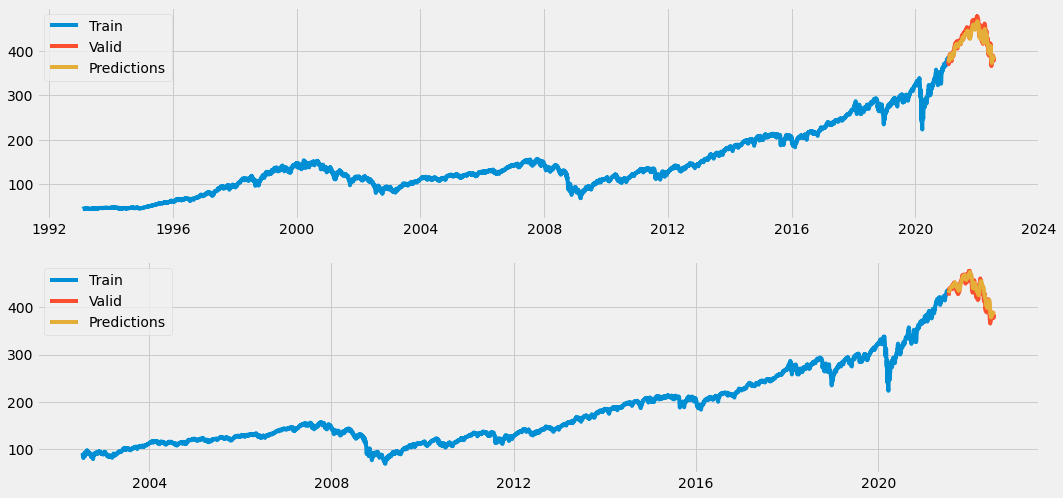

In [113]:
train = data[:training_data_length]
valid = data[training_data_length:]
valid["Predictions"] = predictions
valid["Error"] = abs(valid["Close"] - valid["Predictions"])

recent_train = recent_data[:recent_training_data_length]
recent_valid = recent_data[recent_training_data_length:]
recent_valid["Predictions"] = recent_predictions
recent_valid["Error"] = abs(recent_valid["Close"] - recent_valid["Predictions"])

plt.figure(figsize = (16,8))
plt.title("SPY Price History")
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Price (USD)", fontsize = 18)

plt.subplot(211)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Valid", "Predictions"], loc = "best")

plt.subplot(212)
plt.plot(recent_train["Close"])
plt.plot(recent_valid[["Close", "Predictions"]])
plt.legend(["Train", "Valid", "Predictions"], loc = "best")
plt.show()

In [114]:
valid

,Close,Predictions,Error
Date,,,
2021-01-27,374.410004,384.205963,9.795959
2021-01-28,377.630005,382.269989,4.639984
2021-01-29,370.070007,380.819214,10.749207
2021-02-01,376.230011,378.065399,1.835388
2021-02-02,381.549988,377.026886,4.523102
...,...,...,...
2022-07-11,384.230011,386.128845,1.898834
2022-07-12,380.829987,386.377960,5.547974
2022-07-13,378.829987,385.338623,6.508636


In [115]:
recent_valid

,Close,Predictions,Error
Date,,,
2021-07-19,424.970001,436.870850,11.900848
2021-07-20,431.059998,435.309509,4.249512
2021-07-21,434.549988,434.416870,0.133118
2021-07-22,435.459991,434.384399,1.075592
2021-07-23,439.940002,434.845734,5.094269
...,...,...,...
2022-07-11,384.230011,388.221100,3.991089
2022-07-12,380.829987,388.809845,7.979858
2022-07-13,378.829987,388.520569,9.690582


In [116]:
new_df = df.filter(["Close"])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
new_x_test = []
new_x_test.append(last_60_days_scaled)
new_x_test = np.array(new_x_test)
new_x_test = np.reshape(new_x_test, (new_x_test.shape[0], new_x_test.shape[1], 1))
pred_price = model.predict(new_x_test, )
pred_price = scaler.inverse_transform(pred_price)
print("Predicted close price for SPY for next trading day using full dataset: ${:0.2f}".format(round(pred_price[0][0], 2)))

recent_new_df = recent_df.filter(["Close"])
recent_last_60_days = recent_new_df[-60:].values
recent_last_60_days_scaled = scaler.transform(recent_last_60_days)
recent_new_x_test = []
recent_new_x_test.append(recent_last_60_days_scaled)
recent_new_x_test = np.array(recent_new_x_test)
recent_new_x_test = np.reshape(recent_new_x_test, (recent_new_x_test.shape[0], recent_new_x_test.shape[1], 1))
recent_pred_price = recent_model.predict(recent_new_x_test, )
recent_pred_price = scaler.inverse_transform(recent_pred_price)

print("Predicted close price for next trading day SPY using a more recent dataset: ${:0.2f}".format(round(recent_pred_price[0][0], 2)))

Predicted close price for SPY for next trading day using full dataset: $377.07
Predicted close price for next trading day SPY using a more recent dataset: $386.31


In [155]:
# Calcualte model accuracy for both datasets
from sklearn.metrics import r2_score

accuracy = r2_score(valid["Close"], valid["Predictions"])
print("Model accuracy for large/complete dataset: {}%".format(round(accuracy * 100, 2)))

recent_accuracy = r2_score(recent_valid["Close"], recent_valid["Predictions"])
print("Model accuracy for recent dataset: {}%".format(round(recent_accuracy * 100, 2)))

Model accuracy for large/complete dataset: 91.2%
Model accuracy for recent dataset: 88.69%
